In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import mkl

mkl.set_num_threads(2)
np.random.seed(1234)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

### Handy utility functions

In [2]:
def append_ones(matrix, axis=1):
    return np.concatenate((matrix, np.ones((matrix.shape[0], 1), dtype=np.float32)), axis=axis)

def zeros(*dims):
    return np.zeros(shape=tuple(dims), dtype=np.float32)

def ones(*dims):
    return np.ones(shape=tuple(dims), dtype=np.float32)

def rand(*dims):
    return np.random.rand(*dims).astype(np.float32)

def randn(*dims):
    return np.random.randn(*dims).astype(np.float32)

def chunks(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def as_matrix(vector):
    return np.reshape(vector, (-1, 1))

def one_hot_encode(labels):
    one_hot = zeros(labels.shape[0], np.max(labels) + 1) 
    one_hot[np.arange(labels.shape[0]), labels] = 1
    return one_hot.astype(np.float32)

def classify(mlp, batch):
    probabilities = forward_pass(mlp, batch, False)
    return np.argmax(probabilities, axis=1)

def tiles(examples):
    rows_count = examples.shape[0]
    cols_count = examples.shape[1]
    tile_height = examples.shape[2]
    tile_width = examples.shape[3]
    
    space_between_tiles = 2
    img_matrix = np.empty(shape=(rows_count * (tile_height + space_between_tiles) - space_between_tiles,  
                                 cols_count * (tile_width + space_between_tiles) - space_between_tiles))
    img_matrix.fill(np.nan)

    for r in range(rows_count):
        for c in range(cols_count):
            x_0 = r * (tile_height + space_between_tiles)
            y_0 = c * (tile_width + space_between_tiles)
            ex_min = np.min(examples[r, c])
            ex_max = np.max(examples[r, c])
            img_matrix[x_0:x_0 + tile_height, y_0:y_0 + tile_width] = (examples[r, c] - ex_min) / (ex_max - ex_min)
    
    plt.matshow(img_matrix, cmap='gray', interpolation='none')
    plt.axis('off')
    plt.show()

def draw_rbm_filters(rbm):
    filters = np.reshape(np.transpose(rbm.W)[:-1, :-1], newshape=(8, -1, 28, 28))
    tiles(filters)

def draw_layer_filters(layer):
    filters = np.reshape(layer.W[:-1].T, newshape=(8, -1, 28, 28))
    tiles(filters)

### Activation functions

In [3]:
def sigmoid(batch, stochastic=False):
    activations = 1.0 / (1.0 + np.exp(-batch))
    if stochastic:
        return activations > rand(*activations.shape).astype(np.float32)
    else:
        return activations

def sigmoid_derivative(batch):
    s = sigmoid(batch)
    return s * (1.0 - s)

def softmax(batch):
    soft_batch = np.exp(batch - np.max(batch, axis=1, keepdims=True))
    return soft_batch / np.sum(soft_batch, axis=1, keepdims=True)

# MNIST dataset

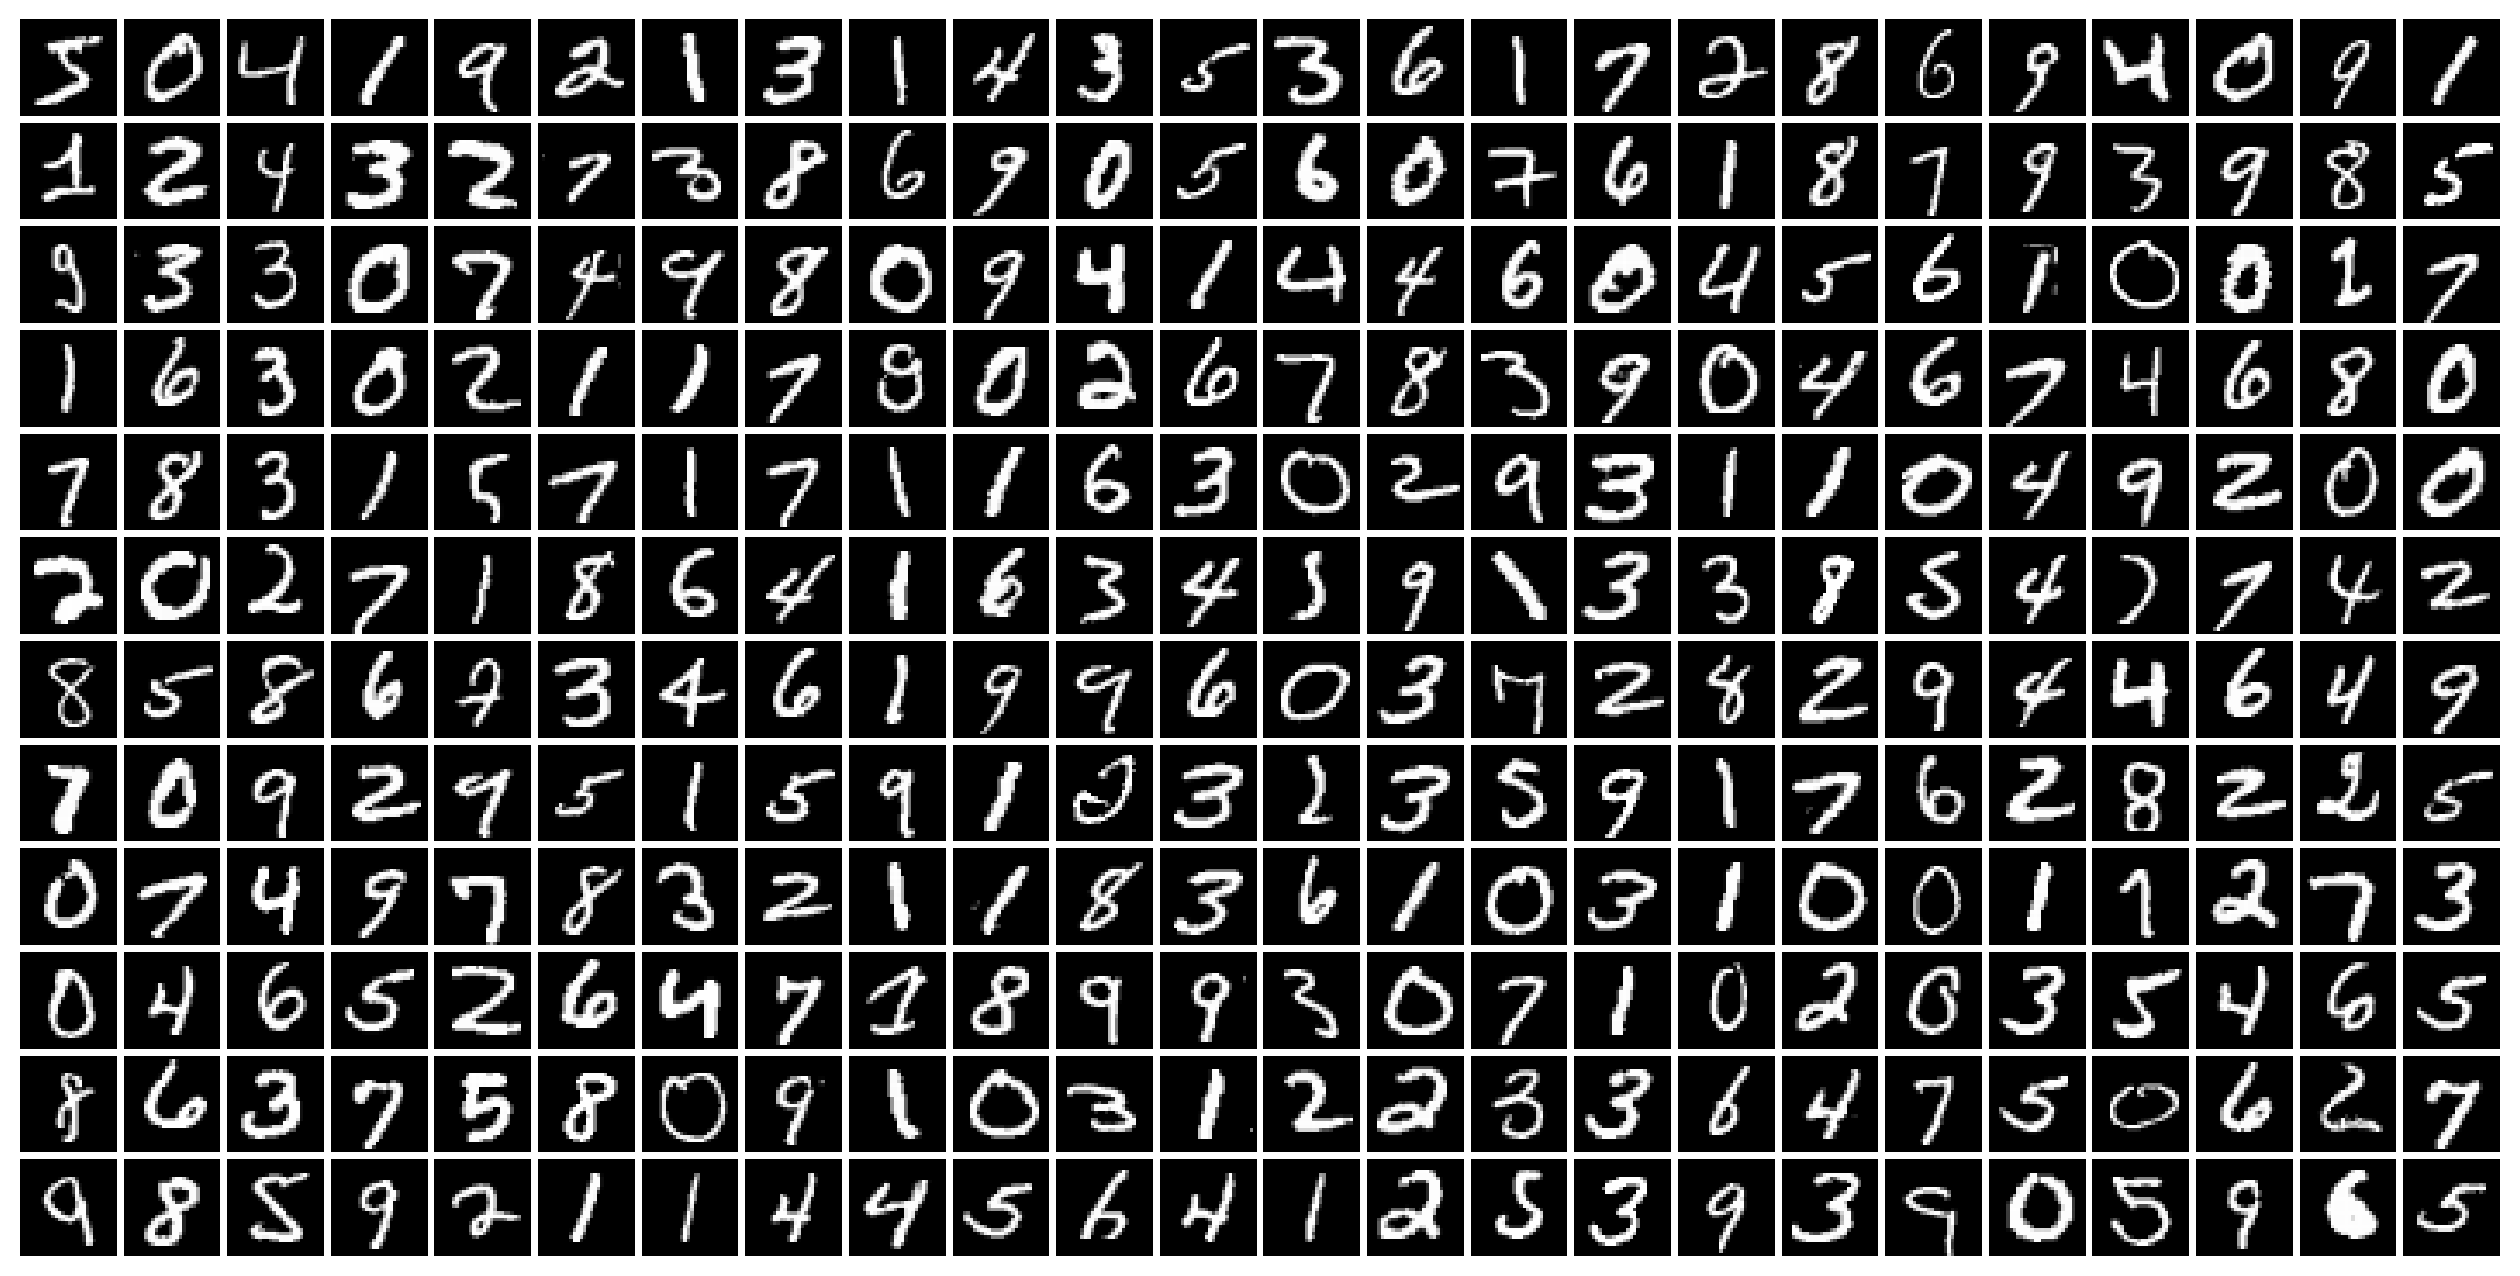

In [4]:
import mnist
digits = np.reshape(mnist.train_images()[:12*24], newshape=(12, 24, 28, 28))
tiles(digits)

# ReLU and Max-Norm regularization

In [5]:
def relu(batch, stochastic=False):
    if stochastic==False:
        return np.maximum(0,batch)
    else:
        return np.maximum(0, batch + np.random.normal(size=batch.shape,scale=np.sqrt(sigmoid(batch))))

def relu_derivative(batch):
    return (batch>0).astype(int)

In [6]:
def limit_weights(weights, limit):
    
    limits = ones(*weights.shape)
    columns = np.linalg.norm(weights, axis=0)
    limits[:, columns > limit] = limit / columns[columns > limit]
    
    return weights * limits

# RBM & DBN training

In [7]:
class Rbm:
    def __init__(self, visible_size, hidden_size, visible_act_func, hidden_act_func, 
                 learning_rate, momentum, weight_limit):
        self.visible_size = visible_size
        self.hidden_size = hidden_size
        
        self.visible_act_func = visible_act_func
        self.hidden_act_func = hidden_act_func
        
        self.learning_rate = learning_rate
        self.momentum = momentum
        
        self.weight_limit = weight_limit
        
        self.reset()
    
    def reset(self):
        self.W = np.random.normal(scale=0.01, size=(self.visible_size+1, self.hidden_size+1)).astype(np.float32)
        self.W[:, -1] = 0.0
        self.W[-1, :] = 0.0
        self.M = zeros(self.visible_size+1, self.hidden_size+1)

In [8]:
def cdk(rbm, minibatch, k=1):
    observations_count = minibatch.shape[0]

    positive_visible = minibatch
    negative_visible = append_ones(zeros(observations_count, rbm.visible_size))

    positive_hidden = append_ones(zeros(observations_count, rbm.hidden_size))
    negative_hidden = append_ones(zeros(observations_count, rbm.hidden_size))

    z = minibatch @ rbm.W[:, :-1]
    positive_hidden[:, :-1] = rbm.hidden_act_func(z)
    negative_hidden[:, :-1] = rbm.hidden_act_func(z, stochastic=True)

    for cd_i in range(k):
        negative_visible[:, :-1] = rbm.visible_act_func(negative_hidden @ rbm.W[:-1, :].T,
                                                        stochastic=True)
        z = negative_visible @ rbm.W[:, :-1]
        if cd_i < (k - 1):
            negative_hidden[:, :-1] = rbm.hidden_act_func(z, stochastic=True)
        else:
            negative_hidden[:, :-1] = rbm.hidden_act_func(z)

    rbm.M *= rbm.momentum
    rbm.M += (rbm.learning_rate / observations_count) * positive_visible.T @ positive_hidden
    rbm.M -= (rbm.learning_rate / observations_count) * negative_visible.T @ negative_hidden

    rbm.W += rbm.M;
    
    if rbm.weight_limit > 0.0:
        rbm.W[:-1, :-1] = limit_weights(rbm.W[:-1, :-1], rbm.weight_limit)

def reconstuction_error(rbm, minibatch):
    observations_count = minibatch.shape[0]
    visible = zeros(observations_count, rbm.visible_size)
    hidden = append_ones(zeros(observations_count, rbm.hidden_size))
    
    hidden[:, :-1] =  rbm.hidden_act_func(minibatch @ rbm.W[:, :-1], stochastic=True)
    visible = rbm.visible_act_func(hidden @ np.transpose(rbm.W[:-1, :]))
    
    error = minibatch[:, :-1] - visible
    error = np.sum(np.square(error)) / observations_count
    
    return error

In [9]:
def propagate_up(dbn, layers_count, visible):
    for i in range(layers_count):
        visible = append_ones(dbn[i].hidden_act_func(visible @ dbn[i].W[:, :-1]))
    return visible

def propagate_down(dbn, layers_count, hidden):
    for i in reversed(range(layers_count)):
        hidden = append_ones(dbn[i].visible_act_func(hidden @ np.transpose(dbn[i].W[:-1, :])))
    return hidden

def dbn_reconstuction_error(dbn, layer_idx, minibatch):
    propagated = propagate_up(dbn, layer_idx, minibatch)
    return reconstuction_error(dbn[layer_idx], propagated)

def train_dbn_layer(dbn, layer_idx, dataset, batch_size):
    dataset = propagate_up(dbn, layer_idx, dataset)
    
    batches_limit = dataset.shape[0] / batch_size
    for batch_idx, batch in enumerate(chunks(dataset, batch_size)):
        cdk(dbn[layer_idx], batch)
        if batch_idx % round(batches_limit / 40) == 0: print("#", end="")
            
def run_dbn_training(dbn, dataset, monitoring_set, batch_size, epochs_count, target_momentum=0.9):
    for layer_idx in range(len(dbn)):
        print("\nLearning layer {}".format(layer_idx+1))

        for epoch in range(epochs_count):
            print("Epoch {}:".format(epoch+1),  end="\t")

            if epoch == 5:
                dbn[layer_idx].momentum = target_momentum

            start_time = time.time()
            train_dbn_layer(dbn, layer_idx, dataset, batch_size)
            elapsed = time.time() - start_time

            error = dbn_reconstuction_error(dbn, layer_idx, monitoring_set)
            print("\telapsed: {0:>2.2f}s, reconstruction error: {1:>2.2f}".format(elapsed, error))  

# MLP training

In [10]:
class Layer:
    def __init__(self, visible_size, hidden_size, activation_fun, d_activation_fun, 
                 learning_rate, momentum, weight_limit):
        self.visible_size = visible_size
        self.hidden_size = hidden_size
        
        self.activation_fun = activation_fun
        self.d_activation_fun = d_activation_fun
                
        self.learning_rate = learning_rate
        self.momentum = momentum
        
        self.weight_limit = weight_limit
        
        self.reset()
    
    def reset(self):
        self.W = np.random.normal(scale=0.01, size=(self.visible_size+1, self.hidden_size)).astype(np.float32)
        self.W[-1, :] = 0.0
        
        self.activations = None
        self.d_activations = None
        self.deltas = None

        self.M = zeros(self.visible_size+1, self.hidden_size)

### Forward pass

In [11]:
def forward_pass(mlp, batch, compute_derivatives):
    visible = batch
    
    for layer_idx, layer in enumerate(mlp):
        z=np.dot(visible,layer.W)
        layer.activations=append_ones(layer.activation_fun(z))
        
        if compute_derivatives and (layer_idx < len(mlp) - 1):
            layer.d_activations=layer.d_activation_fun(z)
            
        
        visible = layer.activations
        
    return visible[:, :-1]

### Error backpropagation

In [12]:
def error_backpropagate(mlp, batch):
    observations_count = batch.shape[0]

    for layer_idx, layer in reversed(list(enumerate(mlp))):
        if layer_idx > 0:
            prev_layer = mlp[layer_idx - 1]
            visible = prev_layer.activations
            
            prev_layer.deltas=np.dot(layer.deltas,layer.W[:-1].T)*prev_layer.d_activations
        else:
            visible = batch
        
        layer.M=layer.momentum*layer.M-layer.learning_rate*(np.dot(visible.T,layer.deltas)/observations_count)
        
        layer.W += layer.M
        
        if layer.weight_limit > 0.0:
            layer.W[:-1, :] = limit_weights(layer.W[:-1, :], layer.weight_limit)

### Training procedure

In [13]:
def train_mlp(mlp, dataset, labels, batch_size):
    batches_limit = dataset.shape[0] / batch_size
    
    batched_data = chunks(dataset, batch_size)
    batched_labels = chunks(labels, batch_size)
    
    for batch_idx, (batch, batch_labels) in enumerate(zip(batched_data, batched_labels)):
        # Forward pass: compute activatations and derivatives of activations
        y = forward_pass(mlp, batch, True)
        
        mlp[-1].deltas=y-batch_labels
        
        # Once softmax deltas are set, we may backpropagate errors
        error_backpropagate(mlp, batch)
        
        if batch_idx % round(batches_limit / 40) == 0: print("#", end="")

In [14]:
def run_mlp_training(mlp, train_set, train_labels, validation_set, validation_labels,
                     batch_size, epochs_count, target_momentum=0.95):
    for epoch in range(epochs_count):
        print("Epoch {}:".format(epoch+1),  end="\t")
        
        if epoch == 5:
            for layer in mlp: layer.momentum = target_momentum
        
        start_time = time.time()
        train_mlp(mlp, train_set, train_labels, batch_size)
        elapsed = time.time() - start_time

        predictions = classify(mlp, validation_set)
        accuracy = 100.0 * np.sum(predictions == validation_labels) / predictions.shape[0]
        print("\telapsed: {0:>2.2f}s, accuracy: {1:>2.2f}".format(elapsed, accuracy))

    print("Training finished!")

#  Initializing MLP with DBN weights

Implement initialization of MLP weights (and biases) using weights (and biases) from the DBN layers.

Make sure that the MLP weights (and biases) are **copies** of the DBN weights (and biases). You can use ```np.copy(...)``` function to copy the weights (simple assignment will make a view instead of a copy).

In [15]:
def initialize_mlp(mlp, dbn):
    for i in range(len(dbn)):
        mlp[i].W = np.copy(dbn[i].W[:, :-1])

# MNIST digits classification

In [16]:
DATASET_SIZE = 10000 # 60000 for whole dataset
DIGIT_SIZE = 28

##### Train set #####

mnist_train_images = mnist.train_images().astype(np.float32) / 255.0
mnist_train_labels = mnist.train_labels()

order = np.random.permutation(len(mnist_train_images))
mnist_train_images = mnist_train_images[order]
mnist_train_labels = mnist_train_labels[order]

mnist_train_images = np.reshape(mnist_train_images[:DATASET_SIZE],
                                newshape=(DATASET_SIZE, DIGIT_SIZE*DIGIT_SIZE))
mnist_train_images = append_ones(mnist_train_images)

mnist_train_labels = mnist_train_labels[:DATASET_SIZE]
mnist_train_labels = one_hot_encode(mnist_train_labels)

monitoring_set_indeces = np.random.choice(mnist_train_images.shape[0], 512, replace=False)
monitoring_set = mnist_train_images[monitoring_set_indeces]

##### Test set #####

mnist_test_images = mnist.test_images().astype(np.float32) / 255.0
mnist_test_images = np.reshape(mnist_test_images, newshape=(-1, DIGIT_SIZE*DIGIT_SIZE))
mnist_test_images = append_ones(mnist_test_images)

mnist_test_labels = mnist.test_labels()

In [17]:
VISIBLE_LAYER_SIZE = DIGIT_SIZE*DIGIT_SIZE
HIDDEN_LAYER_SIZE = 256

BATCH_SIZE = 128
EPOCHS_COUNT = 50

MLP_LEARNING_RATE = 0.03
SOFTMAX_LEARNING_RATE = 0.15
RBM_LEARNING_RATE = 0.003
MOMENTUM = 0.5

### Plain vs pretrained comparison

In [18]:
from IPython.core.display import HTML

def compare_pretraining_results(mlp, dbn,
                                train_set, train_labels,
                                validation_set, validation_labels,
                                monitoring_set,
                                batch_size, epochs_count):
    for layer in mlp:
        layer.reset()

    display(HTML('<h3>Plain MLP training</h3>'))
    run_mlp_training(mlp,
                     train_set, train_labels,
                     validation_set, validation_labels,
                     batch_size, epochs_count)
    
    display(HTML('<h3>Input layer filters in the plain MLP</h3>'))
    draw_layer_filters(mlp[0])
    
    display(HTML('<h3>Largest norms of weight-vectors in the plain MLP layers</h3>'))
    for i, layer in enumerate(mlp):
        max_norm = np.max(np.linalg.norm(layer.W[:-1, :], axis=0))
        print('\tlayer {0}: {1:.2f}'.format(i+1, max_norm))
    
    display(HTML('<h3>DBN training</h3>'))
    run_dbn_training(dbn, train_set, monitoring_set, batch_size, epochs_count)
    
    for layer in mlp:
        layer.reset()
    
    initialize_mlp(mlp, dbn)
    
    display(HTML('<h3>Finetuning pretrained MLP</h3>'))
    run_mlp_training(mlp,
                     train_set, train_labels,
                     validation_set, validation_labels,
                     batch_size, epochs_count)
    
    display(HTML('<h3>First layer filters in the DBN</h3>'))
    draw_rbm_filters(dbn[0])
    
    display(HTML('<h3>Input layer filters in the pretrained & finetuned MLP</h3>'))
    draw_layer_filters(mlp[0])

    display(HTML('<h3>Largest norms of weight-vectors in the finetuned MLP layers</h3>'))
    for i, layer in enumerate(mlp):
        max_norm = np.max(np.linalg.norm(layer.W[:-1, :], axis=0))
        print('\tlayer {0}: {1:.2f}'.format(i+1, max_norm))

### Shallow ReLU network

Epoch 1:	########################################	elapsed: 0.37s, accuracy: 11.35
Epoch 2:	########################################	elapsed: 0.39s, accuracy: 31.54
Epoch 3:	########################################	elapsed: 0.35s, accuracy: 65.24
Epoch 4:	########################################	elapsed: 0.32s, accuracy: 74.15
Epoch 5:	########################################	elapsed: 0.32s, accuracy: 80.37
Epoch 6:	########################################	elapsed: 0.34s, accuracy: 89.84
Epoch 7:	########################################	elapsed: 0.33s, accuracy: 92.19
Epoch 8:	########################################	elapsed: 0.32s, accuracy: 93.21
Epoch 9:	########################################	elapsed: 0.36s, accuracy: 94.38
Epoch 10:	########################################	elapsed: 0.37s, accuracy: 93.82
Epoch 11:	########################################	elapsed: 0.34s, accuracy: 94.02
Epoch 12:	########################################	elapsed: 0.36s, accuracy: 95.08
Epoch 13:	###

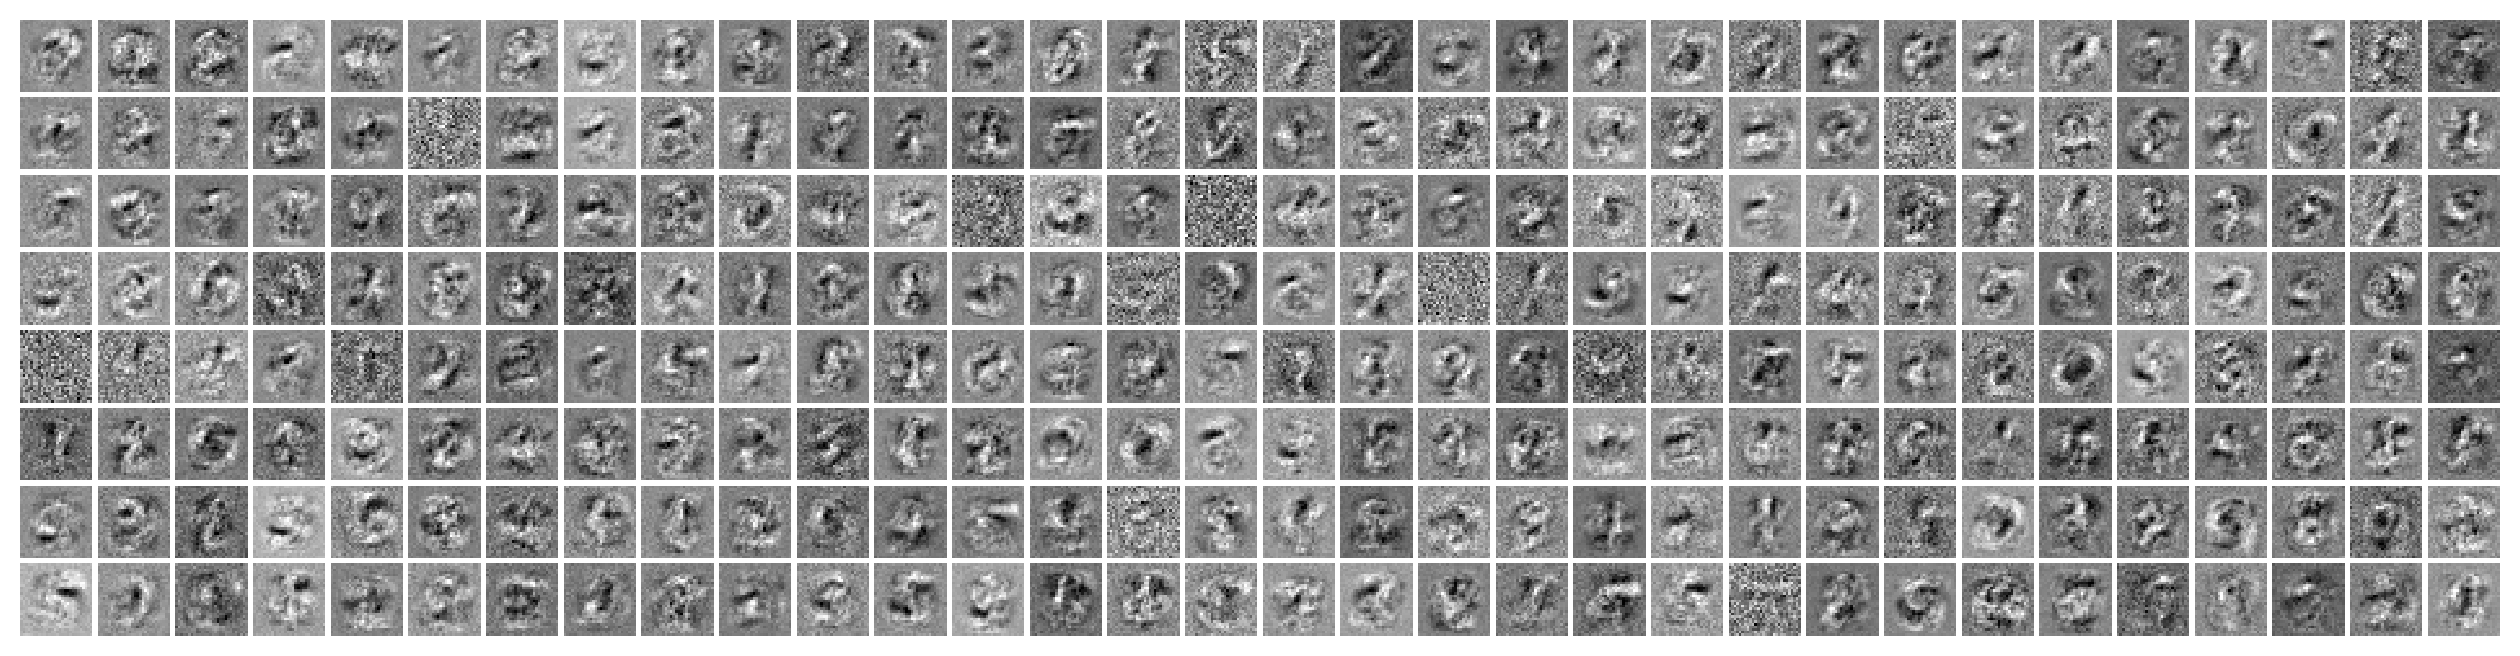

	layer 1: 1.71
	layer 2: 1.00
	layer 3: 4.00



Learning layer 1
Epoch 1:	########################################	elapsed: 0.50s, reconstruction error: 75.37
Epoch 2:	########################################	elapsed: 0.52s, reconstruction error: 54.90
Epoch 3:	########################################	elapsed: 0.52s, reconstruction error: 42.84
Epoch 4:	########################################	elapsed: 0.51s, reconstruction error: 36.50
Epoch 5:	########################################	elapsed: 0.50s, reconstruction error: 32.70
Epoch 6:	########################################	elapsed: 0.51s, reconstruction error: 24.96
Epoch 7:	########################################	elapsed: 0.50s, reconstruction error: 20.96
Epoch 8:	########################################	elapsed: 0.53s, reconstruction error: 18.62
Epoch 9:	########################################	elapsed: 0.52s, reconstruction error: 16.90
Epoch 10:	########################################	elapsed: 0.53s, reconstruction error: 15.66
Epoch 11:	###############################

Epoch 1:	########################################	elapsed: 0.47s, accuracy: 93.98
Epoch 2:	########################################	elapsed: 0.47s, accuracy: 94.83
Epoch 3:	########################################	elapsed: 0.47s, accuracy: 95.36
Epoch 4:	########################################	elapsed: 0.49s, accuracy: 96.32
Epoch 5:	########################################	elapsed: 0.47s, accuracy: 96.35
Epoch 6:	########################################	elapsed: 0.49s, accuracy: 96.53
Epoch 7:	########################################	elapsed: 0.47s, accuracy: 96.64
Epoch 8:	########################################	elapsed: 0.47s, accuracy: 96.63
Epoch 9:	########################################	elapsed: 0.46s, accuracy: 96.85
Epoch 10:	########################################	elapsed: 0.49s, accuracy: 97.08
Epoch 11:	########################################	elapsed: 0.49s, accuracy: 97.20
Epoch 12:	########################################	elapsed: 0.47s, accuracy: 97.27
Epoch 13:	###

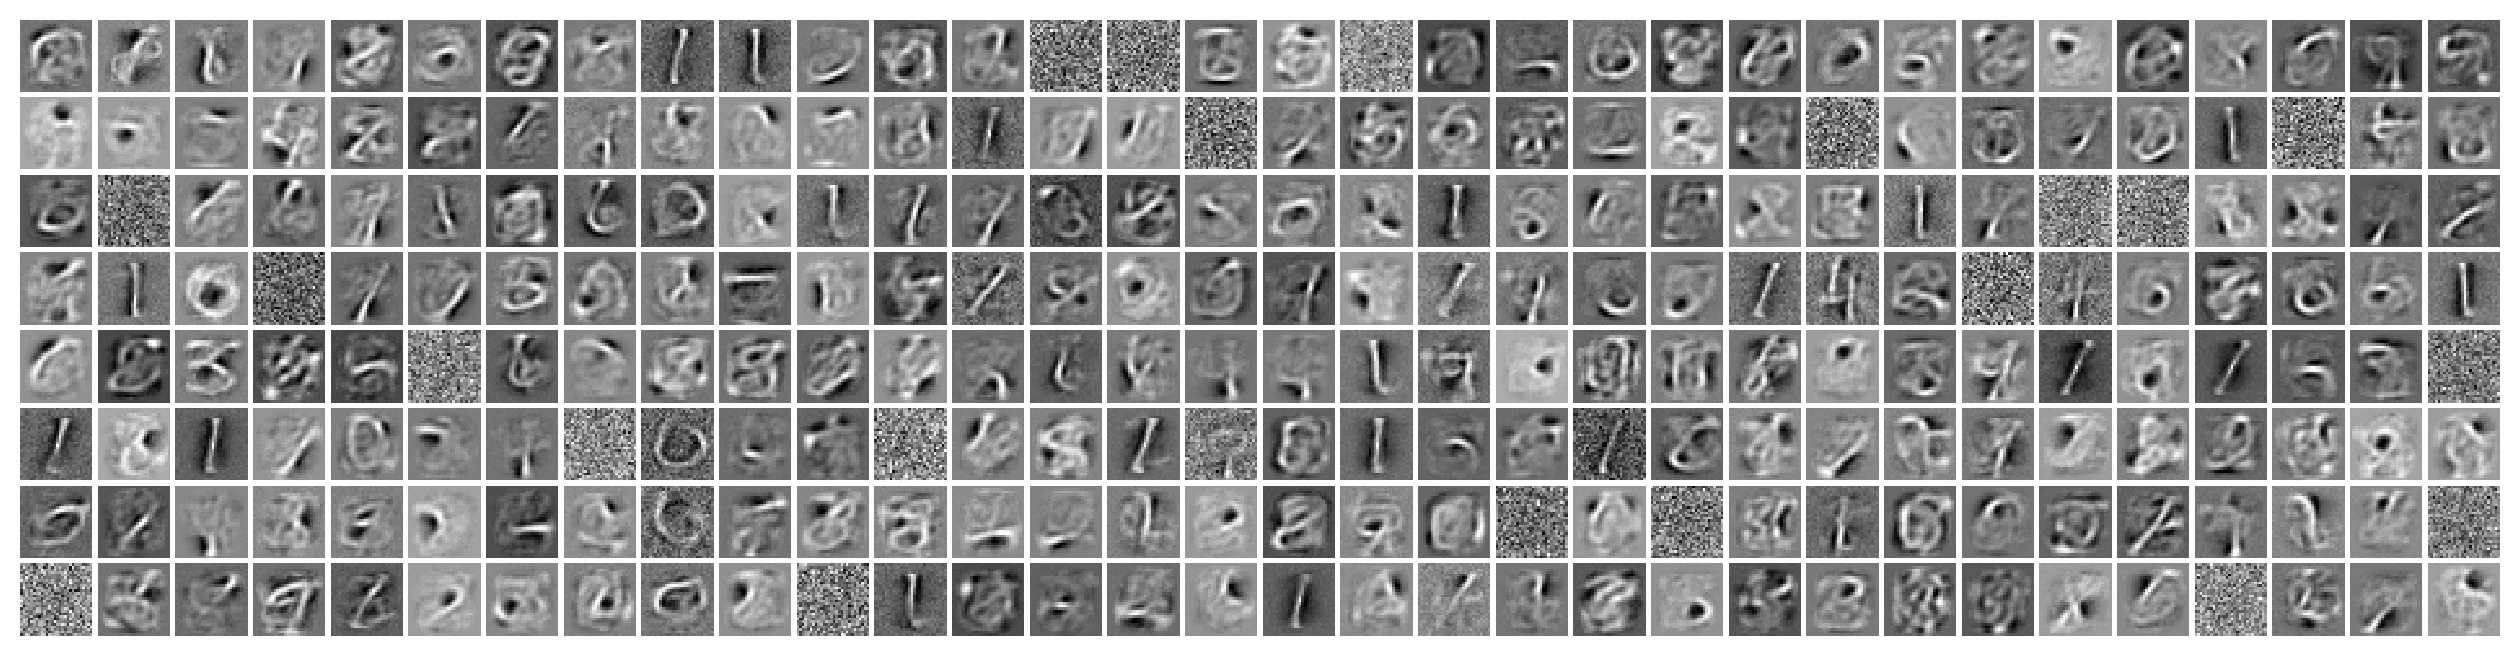

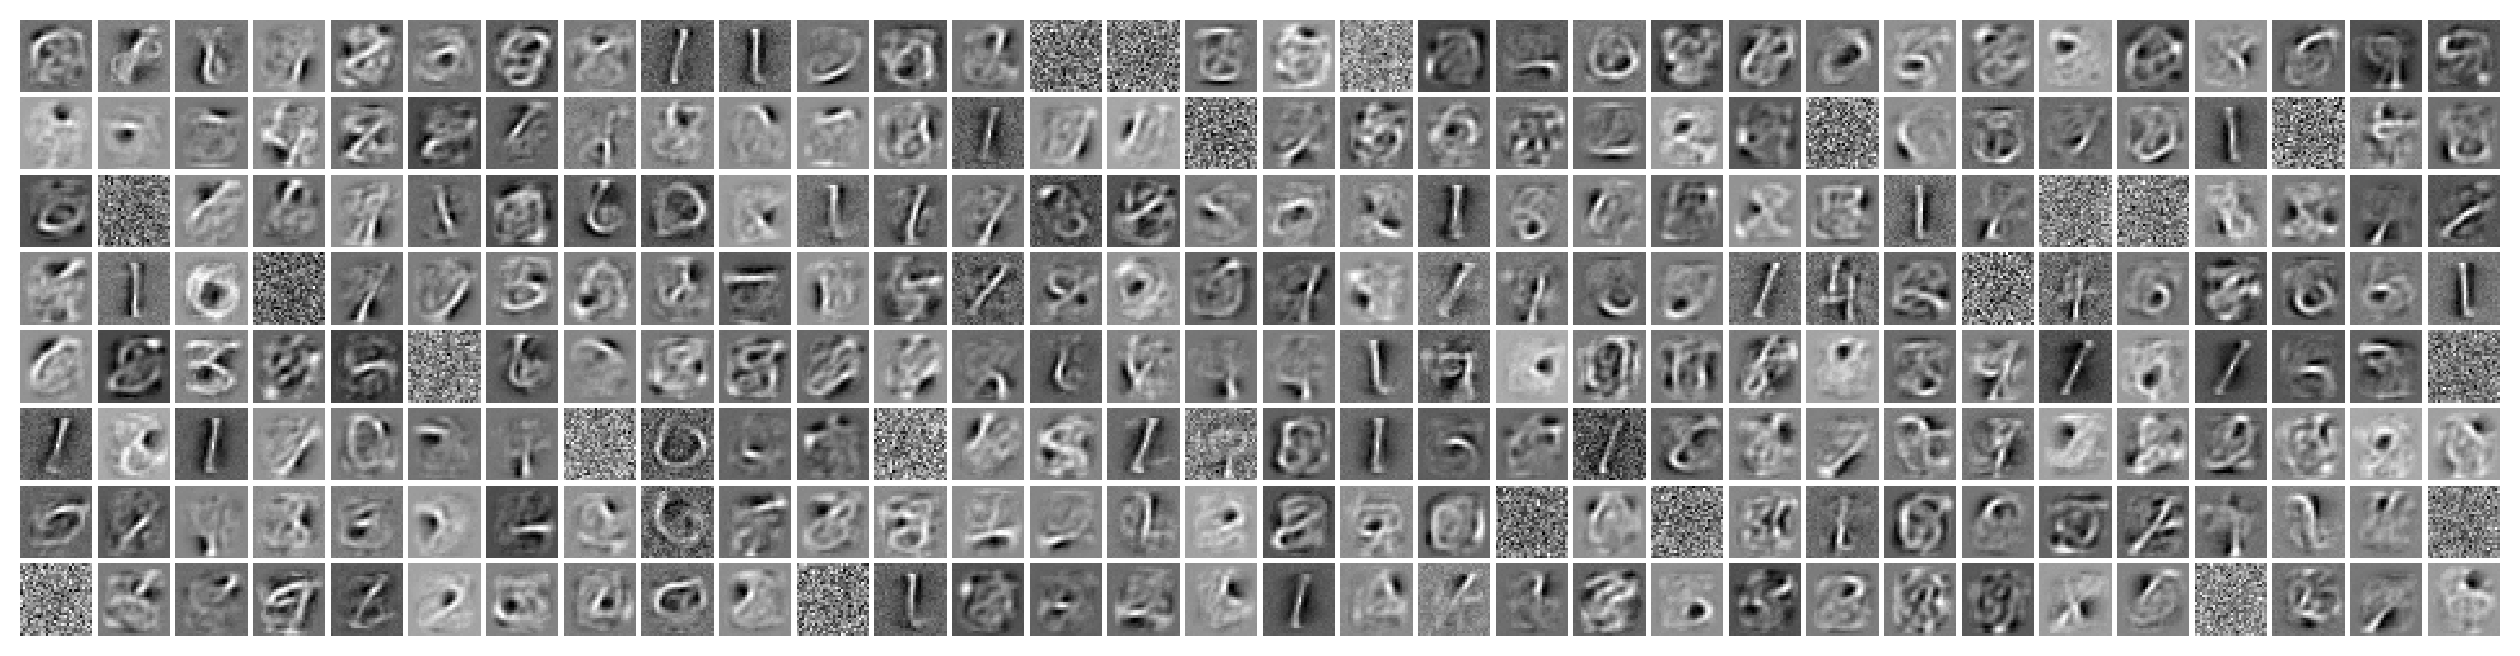

	layer 1: 2.00
	layer 2: 1.00
	layer 3: 4.00


In [19]:
shallow_mlp = [
    Layer(VISIBLE_LAYER_SIZE, HIDDEN_LAYER_SIZE, relu, relu_derivative, MLP_LEARNING_RATE, MOMENTUM,
          weight_limit=2.0),
    Layer(HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE, relu, relu_derivative, MLP_LEARNING_RATE, MOMENTUM,
          weight_limit=1.0),
    Layer(HIDDEN_LAYER_SIZE, 10, softmax, None, SOFTMAX_LEARNING_RATE, MOMENTUM,
          weight_limit=4.0)
]

shallow_dbn = [
    Rbm(VISIBLE_LAYER_SIZE, HIDDEN_LAYER_SIZE, sigmoid, relu, RBM_LEARNING_RATE, MOMENTUM,
        weight_limit=2.0),
    Rbm(HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE, relu, relu, RBM_LEARNING_RATE, MOMENTUM,
        weight_limit=1.0)
]

compare_pretraining_results(shallow_mlp, shallow_dbn,
                            mnist_train_images, mnist_train_labels,
                            mnist_test_images, mnist_test_labels,
                            monitoring_set,
                            BATCH_SIZE, EPOCHS_COUNT)

### Deep ReLU network

Epoch 1:	########################################	elapsed: 0.60s, accuracy: 11.35
Epoch 2:	########################################	elapsed: 0.62s, accuracy: 11.35
Epoch 3:	########################################	elapsed: 0.60s, accuracy: 11.35
Epoch 4:	########################################	elapsed: 0.61s, accuracy: 11.35
Epoch 5:	########################################	elapsed: 0.58s, accuracy: 11.35
Epoch 6:	########################################	elapsed: 0.58s, accuracy: 38.87
Epoch 7:	########################################	elapsed: 0.60s, accuracy: 78.90
Epoch 8:	########################################	elapsed: 0.59s, accuracy: 88.09
Epoch 9:	########################################	elapsed: 0.59s, accuracy: 92.25
Epoch 10:	########################################	elapsed: 0.63s, accuracy: 93.01
Epoch 11:	########################################	elapsed: 0.59s, accuracy: 93.44
Epoch 12:	########################################	elapsed: 0.57s, accuracy: 93.87
Epoch 13:	###

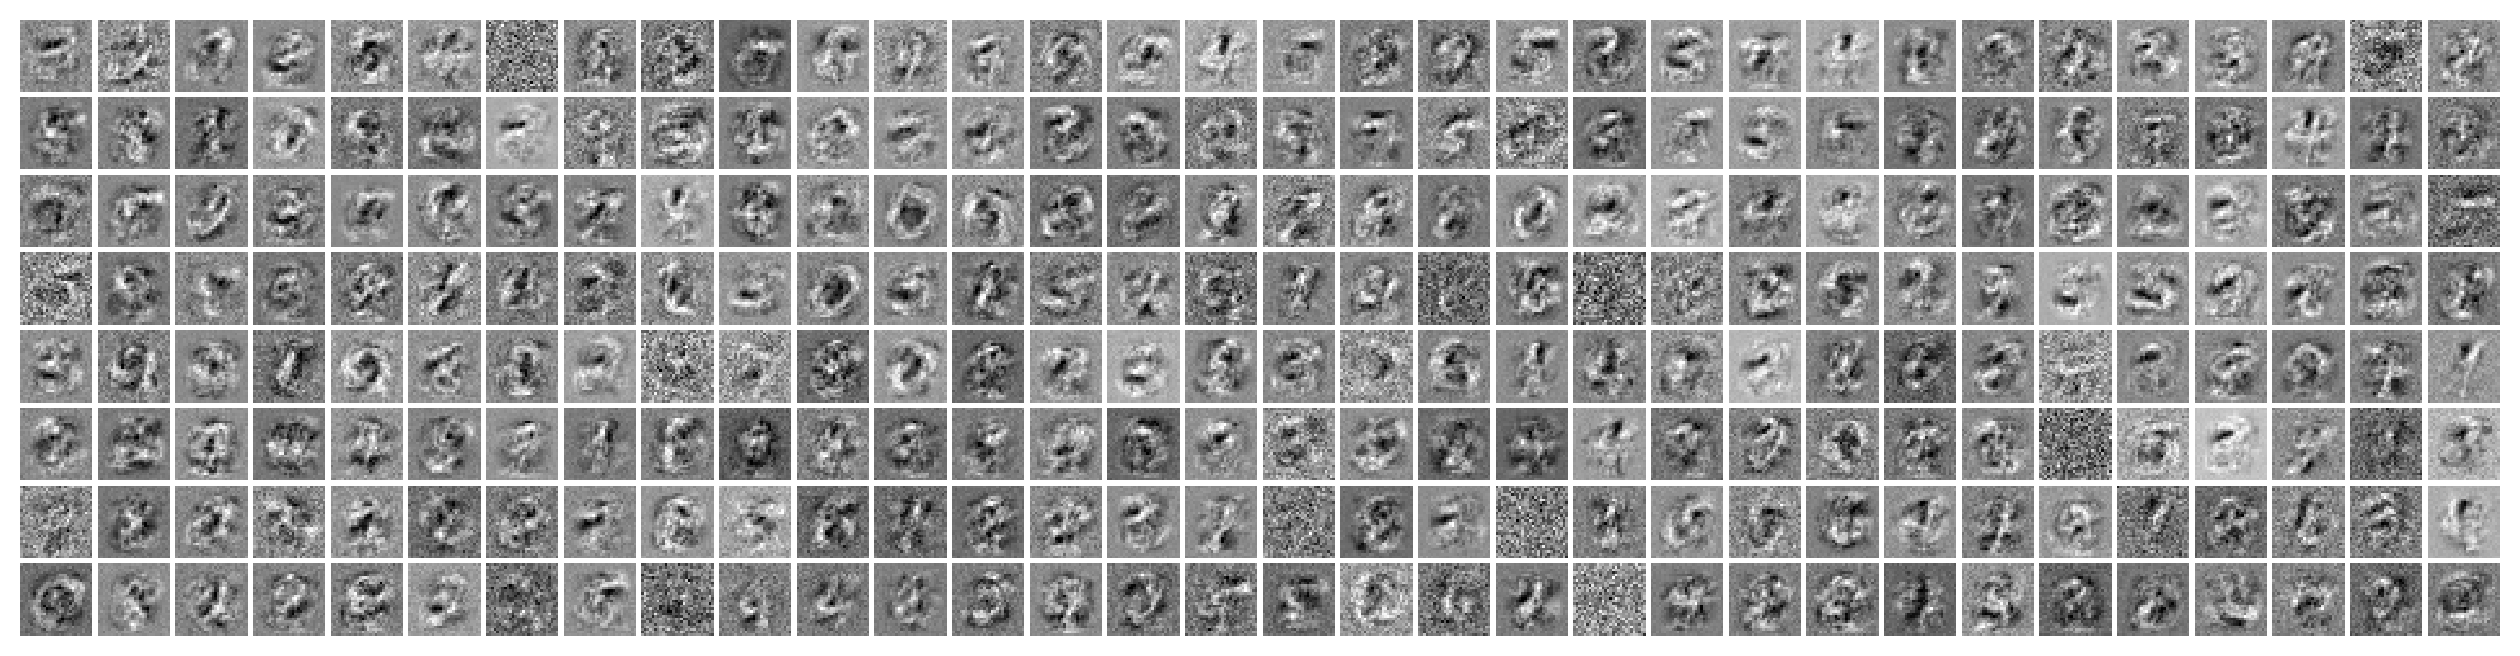

	layer 1: 2.00
	layer 2: 1.00
	layer 3: 0.78
	layer 4: 4.00



Learning layer 1
Epoch 1:	########################################	elapsed: 0.51s, reconstruction error: 74.95
Epoch 2:	########################################	elapsed: 0.51s, reconstruction error: 54.83
Epoch 3:	########################################	elapsed: 0.53s, reconstruction error: 42.51
Epoch 4:	########################################	elapsed: 0.53s, reconstruction error: 36.23
Epoch 5:	########################################	elapsed: 0.53s, reconstruction error: 32.49
Epoch 6:	########################################	elapsed: 0.53s, reconstruction error: 24.70
Epoch 7:	########################################	elapsed: 0.51s, reconstruction error: 20.91
Epoch 8:	########################################	elapsed: 0.54s, reconstruction error: 18.62
Epoch 9:	########################################	elapsed: 0.54s, reconstruction error: 16.92
Epoch 10:	########################################	elapsed: 0.53s, reconstruction error: 15.67
Epoch 11:	###############################

Epoch 1:	########################################	elapsed: 0.63s, accuracy: 94.98
Epoch 2:	########################################	elapsed: 0.63s, accuracy: 95.22
Epoch 3:	########################################	elapsed: 0.64s, accuracy: 95.40
Epoch 4:	########################################	elapsed: 0.61s, accuracy: 96.33
Epoch 5:	########################################	elapsed: 0.60s, accuracy: 96.29
Epoch 6:	########################################	elapsed: 0.62s, accuracy: 96.57
Epoch 7:	########################################	elapsed: 0.61s, accuracy: 97.05
Epoch 8:	########################################	elapsed: 0.61s, accuracy: 97.08
Epoch 9:	########################################	elapsed: 0.61s, accuracy: 96.63
Epoch 10:	########################################	elapsed: 0.62s, accuracy: 97.02
Epoch 11:	########################################	elapsed: 0.64s, accuracy: 97.13
Epoch 12:	########################################	elapsed: 0.63s, accuracy: 97.17
Epoch 13:	###

In [ ]:
deep_mlp = [
    Layer(VISIBLE_LAYER_SIZE, HIDDEN_LAYER_SIZE, relu, relu_derivative, MLP_LEARNING_RATE, MOMENTUM,
          weight_limit=2.0),
    Layer(HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE, relu, relu_derivative, MLP_LEARNING_RATE, MOMENTUM,
          weight_limit=1.0),
    Layer(HIDDEN_LAYER_SIZE, 2 * HIDDEN_LAYER_SIZE, relu, relu_derivative, MLP_LEARNING_RATE, MOMENTUM,
          weight_limit=1.0),
    Layer(2 * HIDDEN_LAYER_SIZE, 10, softmax, None, SOFTMAX_LEARNING_RATE, MOMENTUM,
          weight_limit=4.0)
]

deep_dbn = [
    Rbm(VISIBLE_LAYER_SIZE, HIDDEN_LAYER_SIZE, sigmoid, relu, RBM_LEARNING_RATE, MOMENTUM,
        weight_limit=2.0),
    Rbm(HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE, relu, relu, RBM_LEARNING_RATE, MOMENTUM,
        weight_limit=1.0),
    Rbm(HIDDEN_LAYER_SIZE, 2 * HIDDEN_LAYER_SIZE, relu, relu, RBM_LEARNING_RATE, MOMENTUM,
        weight_limit=1.0)
]

compare_pretraining_results(deep_mlp, deep_dbn,
                            mnist_train_images, mnist_train_labels,
                            mnist_test_images, mnist_test_labels,
                            monitoring_set,
                            BATCH_SIZE, EPOCHS_COUNT)